<a href="https://colab.research.google.com/github/eschwarzbeckf/construction_prices/blob/main/lgbm_forecaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install sktime

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox as box
from scipy.stats import shapiro, norm

In [112]:
from sklearn.ensemble import RandomForestRegressor
from sktime.utils.plotting import plot_series, plot_correlations
from sktime.split import temporal_train_test_split, ExpandingWindowSplitter
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_evaluation import evaluate
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.compose import Id, ColumnEnsembleTransformer, ColumnwiseTransformer
from sktime.transformations.series.subset import ColumnSelect
from sktime.transformations.series.dummies import SeasonalDummiesOneHot

In [5]:
mae = MeanAbsoluteError()
rmse = MeanSquaredError(square_root=True)

In [114]:
df = pd.read_csv('https://raw.githubusercontent.com/eschwarzbeckf/forecast_prices/refs/heads/main/csv/consolidated.csv',parse_dates=True,index_col=0).set_index(pd.date_range('2017-01-31','2025-07-31',freq='ME'))
df.columns = [col.strip() for col in df.columns]
date_index = df.index
y = df['Sales']
x = df.drop('Sales',axis=1)
x = SeasonalDummiesOneHot(freq='M').fit_transform(x)

In [115]:
y_train_index, y_test_index, x_train_index, x_test_index = temporal_train_test_split(y=y,X=x,test_size=6)

In [8]:
df.columns.tolist()

['Sales',
 'Baja California',
 'Baja California Sur',
 'Jalisco',
 'Sinaloa',
 'Sonora',
 'Varilla corrugada',
 'Estructuras',
 'Nitrógeno, oxigeno y gas carbónico',
 'Alambres de fierro y acero',
 'Alambrón',
 'Asfalto y mezclas asfálticas',
 'Azulejos y losetas de cerámica',
 'Barnices y lacas',
 'Bloques y tabiques de concreto',
 'Cal hidratada',
 'Calentadores para agua',
 'Cemento',
 'Productos de alambre',
 'Concreto premezclado',
 'Alambres y cables con aislamiento',
 'Vidrio plano',
 'Otros productos químicos',
 'Pinturas',
 'Fibracel y tablero aglomerado',
 'Ladrillos',
 'Laminas y perfiles de plástico',
 'Piezas metálicas fundidas y moldeadas',
 'Productos de asbesto',
 'Muebles y accesorios para baño',
 'Válvulas para uso doméstico',
 'Otros productos de hule',
 'Maderas de pino y otras maderas',
 'Otros productos de concreto',
 'Perfiles de hierro y acero',
 'Afinación y laminación de aluminio',
 'Soldaduras',
 'Triplay',
 'Tubos y postes de hierro y acero',
 'Tubos de cobr

In [21]:
from lightgbm import LGBMRegressor

/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0

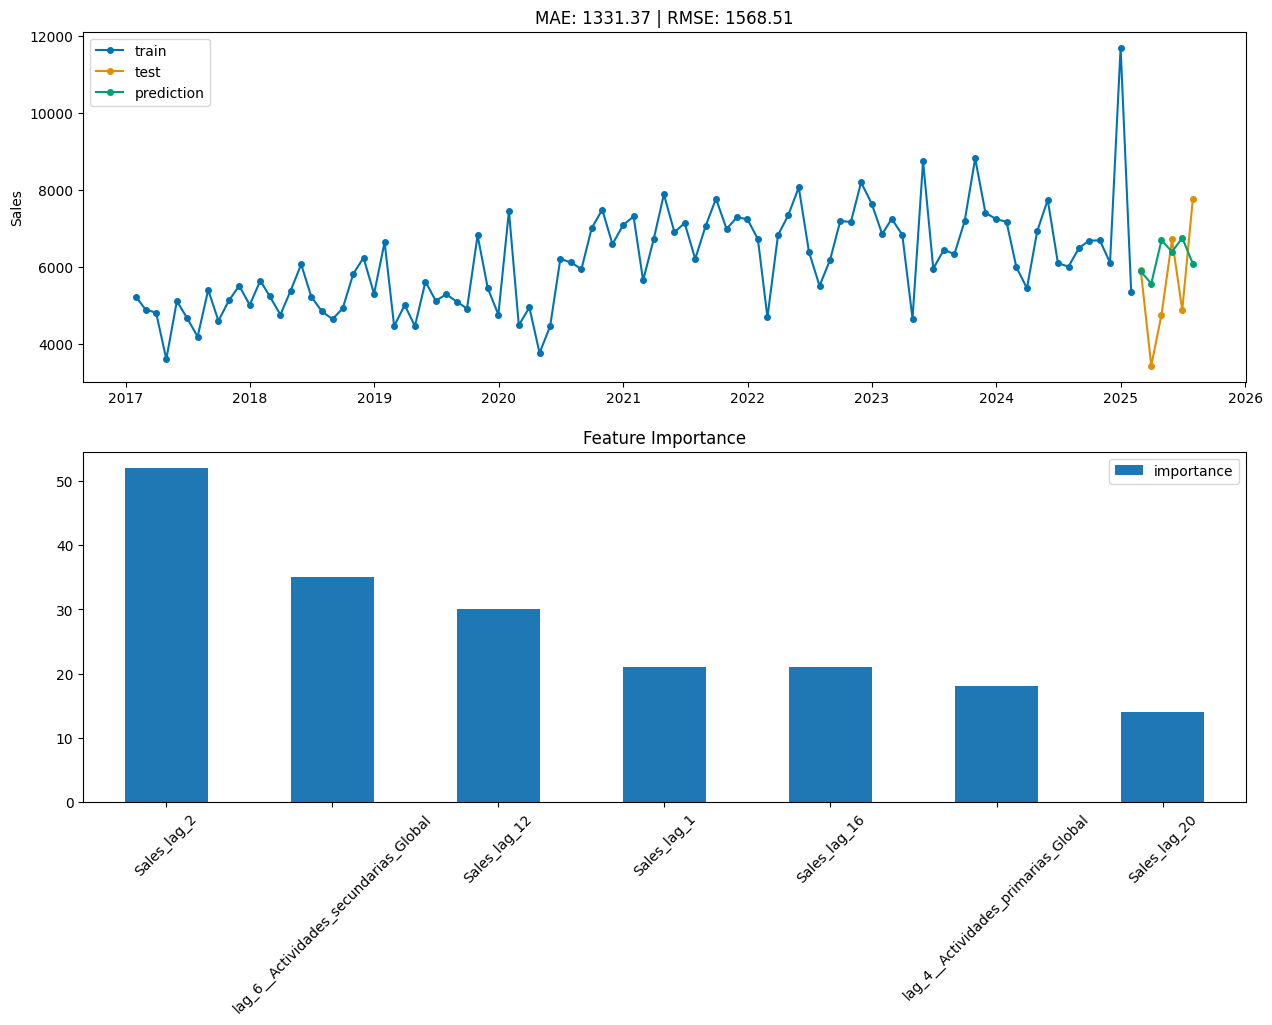

In [99]:
y_train, y_test, x_train, x_test = temporal_train_test_split(y=y.reset_index(drop=True),X=x.reset_index(drop=True),test_size=6)
estimator = LGBMRegressor(max_depth=8,random_state=42, verbose=-1)

w_y_transf = False
w_x_transf = True

ws = WindowSummarizer(lag_feature={
    'lag':[1,2,12,16,20]
},n_jobs=-1)

x_transf =  ColumnEnsembleTransformer([
    #('lag_const',Lag(lags=[1],index_out='original') * Imputer('nearest'), ['Cemento']),
    ('lag_act1',Lag(lags=[4],index_out='original') * Imputer('nearest'), ['Actividades primarias Global']),
    ('lag_act2',Lag(lags=[6],index_out='original') * Imputer('nearest'), ['Actividades secundarias Global']),
   # ('lag_act3',Lag(lags=[1,2,3,4],index_out='original') * Imputer('nearest'), ['Actividades terciarias Global']),
   # ('lag_pop',LogTransformer() * Lag(lags=[2,3],index_out='original') * Imputer('nearest'), ['Sonora','Baja California'])
    ],remainder='drop'
) #+ \
#ColumnSelect(['Cemento','Actividades terciarias Global'])

y_transf = Differencer(lags=[1])

if w_y_transf and w_x_transf:
  model = x_transf ** ( y_transf * make_reduction(estimator=estimator,strategy='recursive',pooling='global',window_length=None,transformers=[ws],windows_identical=True))
  model.fit(y=y_train,X=x_train,fh=np.arange(1,7))
  y_train_transf = y_transf.fit_transform(y_train)
  x_train_transf = pd.concat([ws.fit_transform(y_train_transf),x_transf.fit_transform(x_train)],axis=1) # Convert Series to DataFrame
  y_test_transf = y_transf.transform(y_train)
  x_test_transf = pd.concat([ws.transform(y_test_transf),x_transf.transform(x_test)],axis=1) # Convert Series to DataFrame
  estimator.fit(x_train_transf,y_train_transf)
  in_sample_pred = estimator.predict(x_train_transf)
  in_sample_pred = pd.Series(in_sample_pred.ravel())
  in_sample_pred = y_transf.inverse_transform(in_sample_pred)
elif w_y_transf:
  model = ( y_transf * make_reduction(estimator=estimator,strategy='recursive',pooling='global',window_length=None,transformers=[ws],windows_identical=True))
  model.fit(y=y_train,fh=np.arange(1,7))
  y_train_transf = y_transf.fit_transform(y_train)
  x_train_transf = pd.concat([ws.fit_transform(y_train_transf)],axis=1) # Convert Series to DataFrame
  y_test_transf = y_transf.transform(y_train)
  x_test_transf = pd.concat([ws.transform(y_test_transf)],axis=1) # Convert Series to DataFrame
  estimator.fit(x_train_transf,y_train_transf)
  in_sample_pred = estimator.predict(x_train_transf)
  in_sample_pred = pd.Series(in_sample_pred.ravel())
  in_sample_pred = y_transf.inverse_transform(in_sample_pred)
elif w_x_transf:
  model = x_transf ** (make_reduction(estimator=estimator,strategy='recursive',pooling='global',window_length=None,transformers=[ws],windows_identical=True))
  model.fit(y=y_train,X=x_train,fh=np.arange(1,7))
  y_train_transf = y_train.copy()
  x_train_transf = pd.concat([ws.fit_transform(y_train_transf),x_transf.fit_transform(x_train)],axis=1) # Convert Series to DataFrame
  y_test_transf = y_test.copy()
  x_test_transf = pd.concat([ws.transform(y_test_transf),x_transf.transform(x_test)],axis=1) # Convert Series to DataFrame
  estimator.fit(x_train_transf,y_train_transf)
  in_sample_pred = estimator.predict(x_train_transf)
  in_sample_pred = pd.Series(in_sample_pred.ravel())

else:
  model = make_reduction(estimator=estimator,strategy='recursive',pooling='global',window_length=None,transformers=[ws],windows_identical=True)
  model.fit(y=y_train,fh=np.arange(1,7))
  y_train_transf = y_train.copy()
  x_train_transf = pd.concat([ws.fit_transform(y_train_transf)],axis=1) # Convert Series to DataFrame
  y_test_transf = y_test.copy()
  x_test_transf = pd.concat([ws.transform(y_test_transf)],axis=1) # Convert Series to DataFrame
  estimator.fit(x_train_transf,y_train_transf)
  in_sample_pred = estimator.predict(x_train_transf)
  in_sample_pred = pd.Series(in_sample_pred.ravel())



try:
  importances = pd.DataFrame(model.estimator_.feature_importances_,index=model.estimator_.feature_names_in_,columns=['importance']).sort_values('importance',ascending=False)
  estimator_fitted = model.estimator_

except AttributeError:
  try:
    importances = pd.DataFrame(model.forecaster_.estimator_.feature_importances_,index=model.forecaster_.estimator_.feature_names_in_,columns=['importance']).sort_values('importance',ascending=False)
    estimator_fitted = model.forecaster_.estimator_

  except AttributeError:
    importances = pd.DataFrame(model.forecaster_.forecaster_.estimator_.feature_importances_,index=model.forecaster_.forecaster_.estimator_.feature_names_in_,columns=['importance']).sort_values('importance',ascending=False)
    estimator_fitted = model.forecaster_.forecaster_.estimator_


fig, axs = plt.subplots(2,1,figsize=(15,10))
# Predict future values
y_hat = model.predict(X=x_test)
res = y_train - in_sample_pred
y_hat.index = y_test_index.index

plot_series(y_train_index,y_test_index,y_hat,labels=['train','test','prediction'],ax=axs[0])
axs[0].set_title(f'MAE: {round(mae(y_test,y_hat),2)} | RMSE: {round(rmse(y_test,y_hat),2)}')
importances.plot.bar(ax=axs[1])
axs[1].set_title("Feature Importance")
axs[1].set_xticklabels(axs[1].get_xticklabels(),rotation=45)
plt.show()

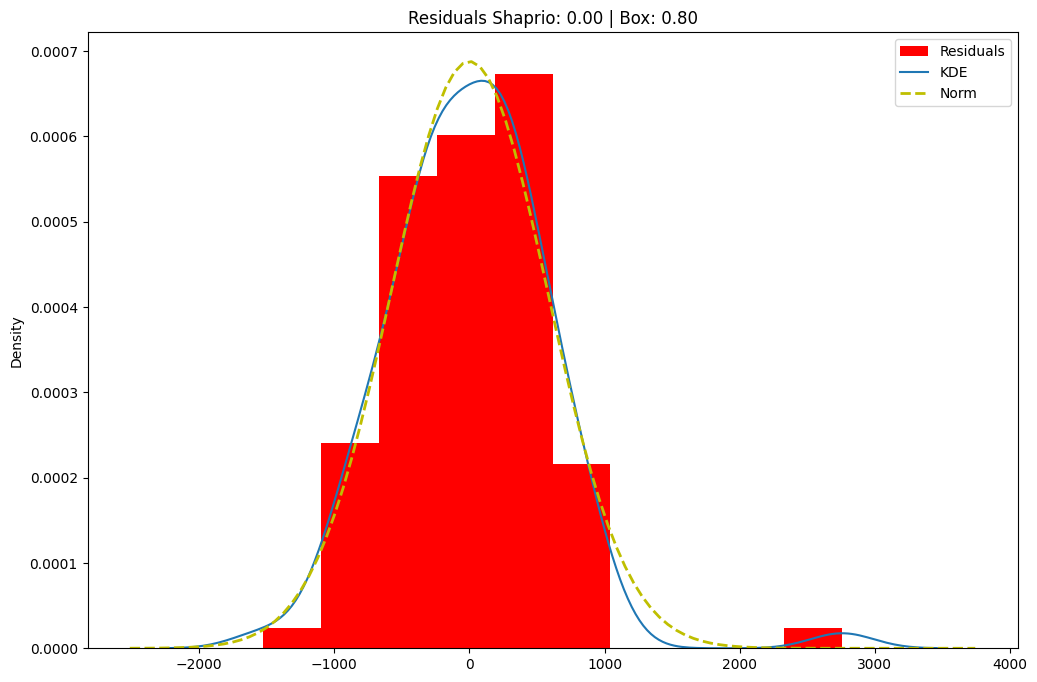

In [100]:
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(res,density=True,color='red',label='Residuals')
sns.kdeplot(res,label='KDE',ax=ax)
mu, std = norm.fit(res)
xmin, xmax = plt.xlim()
resx = np.linspace(xmin, xmax, 100)
p = norm.pdf(resx, mu, std)
ax.plot(resx, p, 'y--', linewidth=2,label='Norm')
ax.set_title(f'Residuals Shaprio: {shapiro(res)[1]:.2f} | Box: {box(res,lags=12)['lb_pvalue'].values[-1]:.2f}')
ax.legend()
plt.show()

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

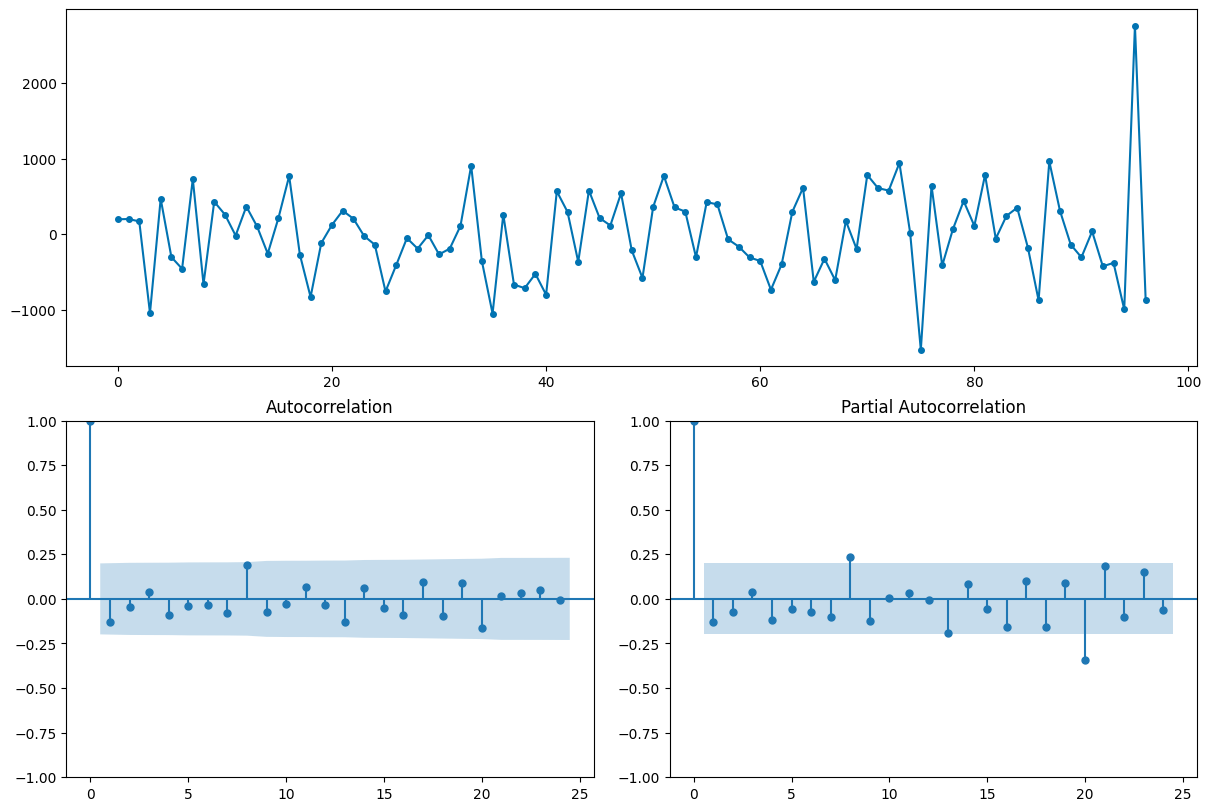

In [101]:
plot_correlations(res, pacf_method='ols')

In [102]:
cv=ExpandingWindowSplitter(fh=np.arange(1,7),step_length=6,initial_window=len(df)-6*5)
results = evaluate(forecaster=model,y=y.reset_index(drop=True),cv=cv,scoring=[mae,rmse],return_data=True)

/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0

/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)


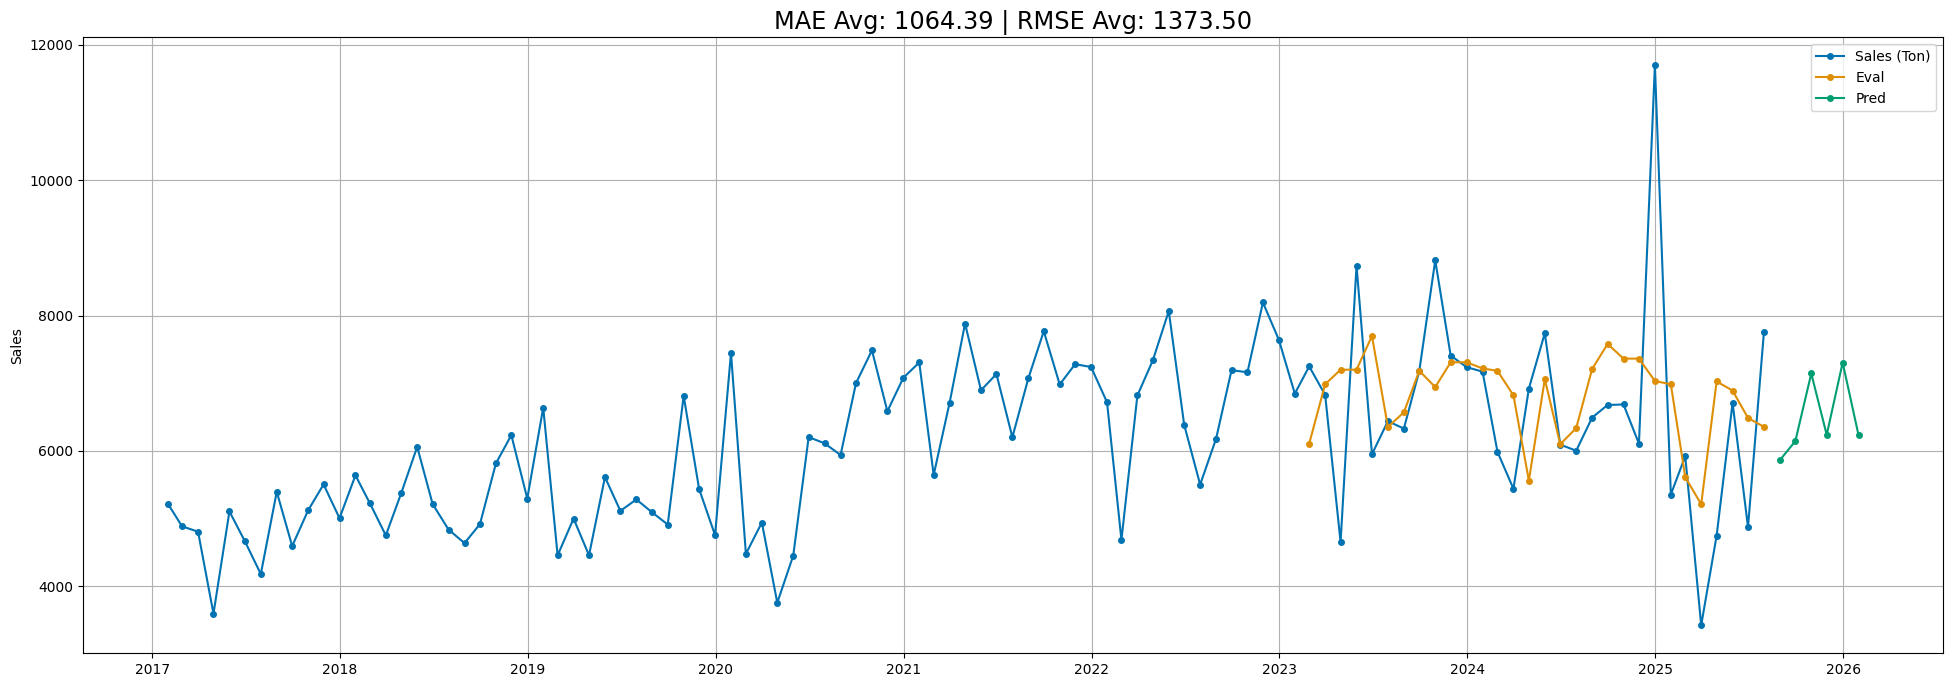

In [103]:
b = ['Sales']
fh = pd.date_range('2025-08',periods=6,freq='ME')
# values = np.ones((6,58)) * x.iloc[-1].values
# x_pred = pd.DataFrame(values,index=fh,columns=x.columns)
test = pd.DataFrame()
for i,d in enumerate(results['y_pred']):
  test = pd.concat([test,d])
test = test.sort_index() # Sort the index
test.index = y.iloc[len(y)-5*6:].index
b.append('Eval')
model.fit(y.reset_index(drop=True),fh=np.arange(1,7))
y_pred = model.predict(fh=np.arange(1,7))
y_pred.index = fh
b.append('Pred')
# y_ci = model.predict_interval(X=x_pred,fh=fh,coverage=[0.8,0.95])

fig, ax = plt.subplots(figsize=(24,8))
plot_series(y,test,y_pred,labels=['Sales (Ton)','Eval','Pred'],title=f'MAE Avg: {results['test_MeanAbsoluteError'].mean():.2f} | RMSE Avg: {results['test_MeanSquaredError'].mean():.2f}',ax=ax)

ax.grid(True)
plt.show()